In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Full_labeled_meme_dataset.csv')

# Define the path where images are stored (adjust this based on your setup)
image_directory = '/content/drive/MyDrive/Dataset/img1'

# Step 1: Load and preprocess the images
# Function to load and preprocess images
def load_image(filename):
    img_path = os.path.join(image_directory, filename)
    img = cv2.imread(img_path)  # Load image

    # Check if the image loaded correctly
    if img is None:
        print(f"Error loading image: {filename}")  # Print error message with filename
        return None # Return None to skip processing this image

    # Change image size to match CNN input shape, e.g., 224x224 for ResNet50
    img = cv2.resize(img, (210,210))  # Resize to 224x224
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return img

# Load all images into a list, filtering out None values
X = [img for img in [load_image(filename) for filename in df['image_name']] if img is not None]

# Check if any images failed to load
if len(X) != len(df):
    print(f"Warning: {len(df) - len(X)} images failed to load.")
# Convert the list to a NumPy array
X = np.array(X)

# Labels (targets) - adjust indices if any images were skipped
y = df['label'].values[:len(X)]

# Step 2: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Data Augmentation to prevent overfitting
# Augment only the training data, not the testing data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
train_datagen.fit(X_train)




Error loading image: 98034.png
Error loading image: 97805.png
Error loading image: 98067.png
Error loading image: 97845.png
Error loading image: 97815.png
Error loading image: 97842.png
Error loading image: 97823.png
Error loading image: 97836.png
Error loading image: 98016.png
Error loading image: 97832.png
Error loading image: 97816.png
Error loading image: 98047.png
Error loading image: 97814.png
Error loading image: 98057.png
Error loading image: 97826.png
Error loading image: 98103.png
Error loading image: 98241.png
Error loading image: 98350.png
Error loading image: 98345.png
Error loading image: 98362.png
Error loading image: 98176.png
Error loading image: 98105.png
Error loading image: 98134.png
Error loading image: 98305.png
Error loading image: 98170.png
Error loading image: 98351.png
Error loading image: 98316.png
Error loading image: 98245.png
Error loading image: 98307.png
Error loading image: 98145.png
Error loading image: 98340.png
Error loading image: 98154.png
Error lo

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Function to train and plot accuracy
def train_and_plot(model, X_train, y_train, X_val, y_val, epochs=60):

    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)
    # Calculate and plot confusion matrix
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, classes=['HATEFUL','NON HATEFUL'])
    plt.show()

    # Plot training history
    plot_training_history(history)


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('history_plot.png')
    plt.show()


    plt.tight_layout()


def plot_confusion_matrix(cm, classes, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Convolution2D, ReLU, AveragePooling2D, Dropout, Flatten, Dense

# Define a function to create the CNN model with reduced filters
def create_cnn_model(input_shape=(210,210, 3)):  # Input size can be adjusted as needed
    seed_value = 42
    # Define the initializer
    init = glorot_uniform(seed=seed_value)
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Reduced filters in each convolutional layer to make the model lighter
    model.add(Convolution2D(16, (5, 5), kernel_initializer=init))  # Reduced from 16 to 8 filters
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, (5, 5), kernel_initializer=init))  # Reduced from 32 to 16 filters
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (5, 5), kernel_initializer=init))  # Reduced from 64 to 32 filters
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (5, 5), kernel_initializer=init))  # Reduced from 128 to 64 filters
    model.add(ReLU())
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.01))

    model.add(Flatten())  # Flatten the output for the Dense layer

    # Reduced number of units in the Dense layer for a lighter model
    model.add(Dense(256, kernel_initializer=init))  # Reduced from 256 to 128 units
    model.add(ReLU())
    model.add(Dropout(0.03))

    model.add(Dense(2, activation='softmax'))  # Final output layer for 2 classes

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Input shape
input_shape=(210,210, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Convolution2D, ReLU, AveragePooling2D, Dropout, Flatten, Dense, Softmax

# Create CNN model
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 206, 206, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 206, 206, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 103, 103, 16)        │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 99, 99, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 49, 49, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 22, 22, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 9, 9, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,925,218 (11.16 MB)

 Trainable params: 2,925,218 (11.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import to_categorical # Import the to_categorical function

# Assuming y_train and y_val are your original target variables
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

Epoch 1/60
57/57 - 13s - 229ms/step - accuracy: 0.8836 - loss: 0.3663 - val_accuracy: 0.9091 - val_loss: 0.3117
Epoch 2/60
57/57 - 11s - 201ms/step - accuracy: 0.8970 - loss: 0.3488 - val_accuracy: 0.9091 - val_loss: 0.3194
Epoch 3/60
57/57 - 2s - 36ms/step - accuracy: 0.8970 - loss: 0.3359 - val_accuracy: 0.9091 - val_loss: 0.3109
Epoch 4/60
57/57 - 2s - 42ms/step - accuracy: 0.8970 - loss: 0.3345 - val_accuracy: 0.9091 - val_loss: 0.3112
Epoch 5/60
57/57 - 3s - 45ms/step - accuracy: 0.8970 - loss: 0.3312 - val_accuracy: 0.9091 - val_loss: 0.3056
Epoch 6/60
57/57 - 3s - 44ms/step - accuracy: 0.8970 - loss: 0.3332 - val_accuracy: 0.9091 - val_loss: 0.3515
Epoch 7/60
57/57 - 3s - 44ms/step - accuracy: 0.8970 - loss: 0.3402 - val_accuracy: 0.9091 - val_loss: 0.3135
Epoch 8/60
57/57 - 2s - 42ms/step - accuracy: 0.8970 - loss: 0.3357 - val_accuracy: 0.9091 - val_loss: 0.3051
Epoch 9/60
57/57 - 2s - 38ms/step - accuracy: 0.8970 - loss: 0.3427 - val_accuracy: 0.9091 - val_loss: 0.3050
Epoch 

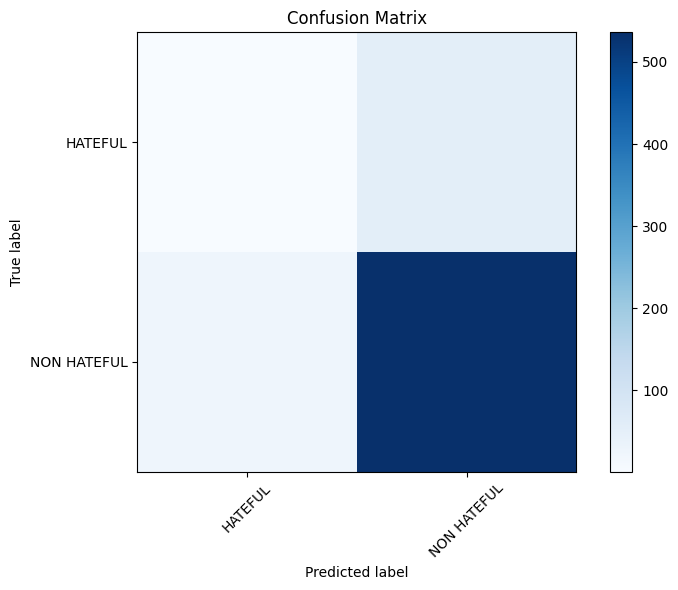

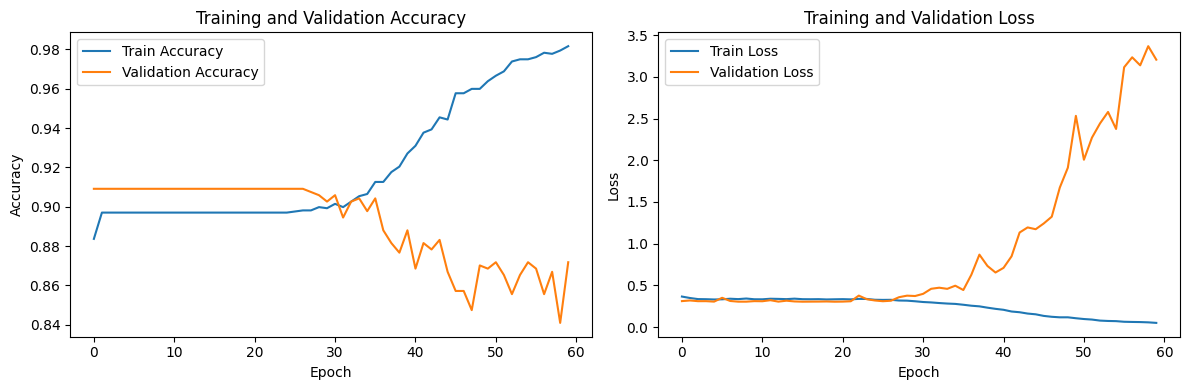

<Figure size 640x480 with 0 Axes>

In [ ]:
train_and_plot(cnn_model, X_train, y_train, X_val, y_val)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming cnn_model is your trained CNN model and X_val, y_val are your validation data
model_predictions = np.argmax(cnn_model.predict(X_val), axis=1)

# Calculate precision, recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(np.argmax(y_val, axis=1), model_predictions, average='weighted')

# Print precision, recall, F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: 0.8281249038609445
Recall: 0.8717532467532467
F1-score: 0.8489392427996539
